[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sentiment Counts:
 label
1    2528
0    2472
Name: count, dtype: int64


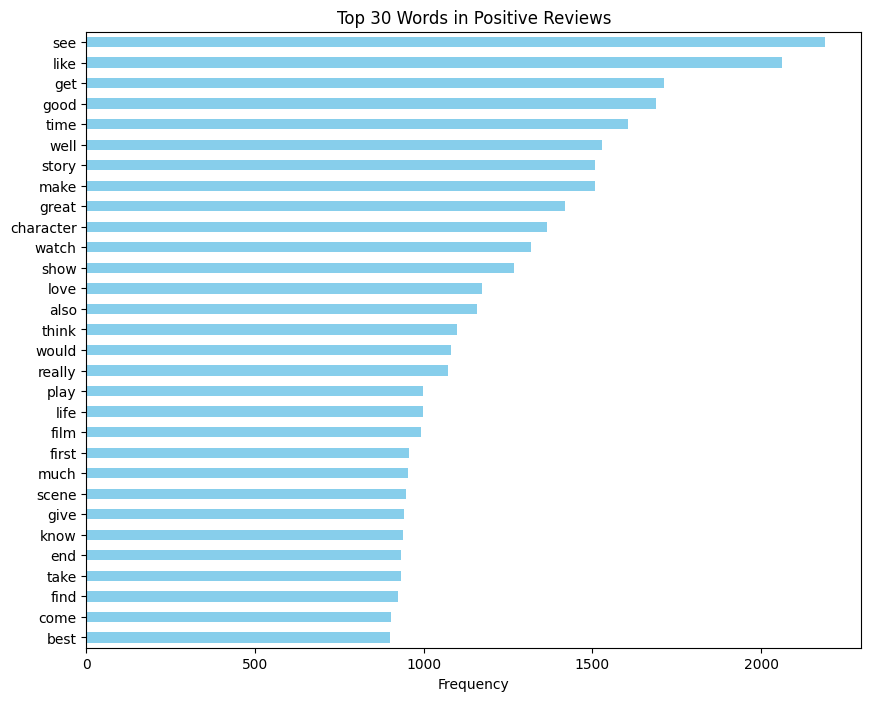

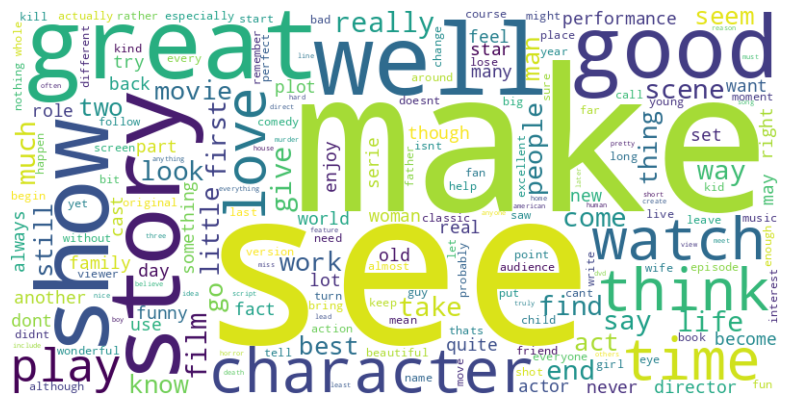

Naive Bayes Accuracy: 0.7
Confusion Matrix:
 [[396  83]
 [217 304]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73       479
           1       0.79      0.58      0.67       521

    accuracy                           0.70      1000
   macro avg       0.72      0.71      0.70      1000
weighted avg       0.72      0.70      0.70      1000



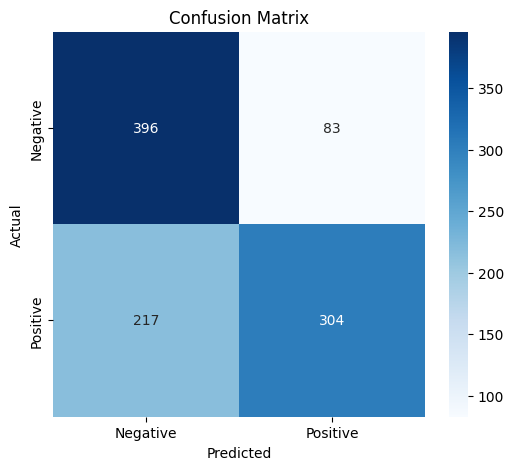

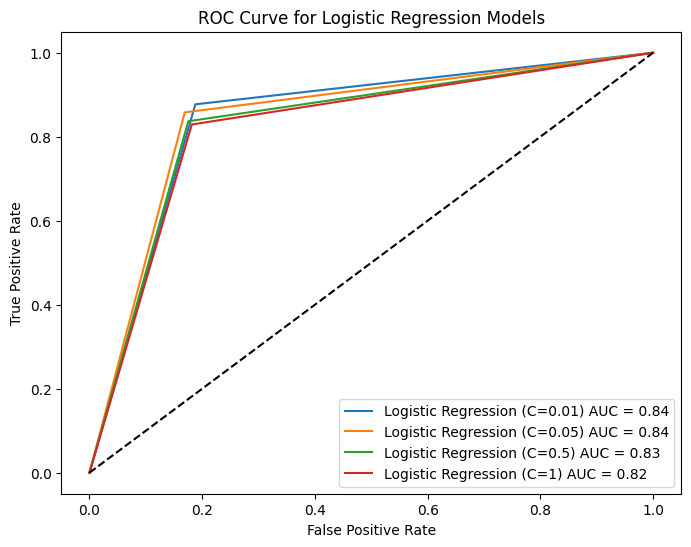

In [6]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng') # Download the missing resource
nltk.download('punkt')

df = pd.read_csv('imdb-reviews_2.csv')

# Count the number of positive and negative sentiments
sentiment_counts = df['label'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)

# Clean the 'review' text and create 'review_processed' column
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
custom_stopwords = {'movie', 'film', 'one', 'make', 'even'}
all_stopwords = stop_words.union(custom_stopwords)
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove short words
    text = ' '.join([word for word in text.split() if len(word) > 2])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in all_stopwords])
    # Lemmatize the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

df['review_processed'] = df['review'].apply(preprocess_text)

# Convert NLTK POS tags to WordNet tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatize with POS tags
def lemmatize_with_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_sentence = []
    for word, tag in tagged_tokens:
        wordnet_tag = get_wordnet_pos(tag)
        if wordnet_tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return ' '.join(lemmatized_sentence)

df['review_processed'] = df['review_processed'].apply(lemmatize_with_pos)

# Plot the most frequent words from positive reviews
positive_reviews = df[df['label'] == 1]
all_words = ' '.join([text for text in positive_reviews['review_processed']])
word_freq = pd.Series(all_words.split()).value_counts()[:30]


plt.figure(figsize=(10,8))
word_freq.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 30 Words in Positive Reviews')
plt.xlabel('Frequency')
plt.show()

# Generate a Word Cloud for positive reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Vectorize the reviews and create a sparse matrix
vectorizer = CountVectorizer(max_features=2500)
X = vectorizer.fit_transform(df['review_processed']).toarray()
y = LabelEncoder().fit_transform(df['label'])

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# Evaluate with confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# Plot confusion matrix with Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Train Logistic Regression models with different C values and plot ROC curves
plt.figure(figsize=(8, 6))
for c in [0.01, 0.05, 0.5, 1]:
    lr_model = LogisticRegression(C=c, max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Logistic Regression (C={c}) AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Logistic Regression Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()